# Modeling 111101011 - drop features

In this notebook, we're specifically working on the dataset formed by dropping (31, 496, 524, 534, 917, 1183, 1299) with the features ('LogGrLivArea', 'GrLivArea', 'TotalHouseArea', 'LivAreaWt', 'AreasSum') dropped.

In [1]:
import itertools
import numpy as np
import pandas as pd
import scipy
from scipy import optimize

pd.set_option('display.precision',20)
pd.set_option('display.max_colwidth',100)

from sklearn import linear_model, svm, tree
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_predict, KFold, cross_val_score, \
                                    GridSearchCV, RandomizedSearchCV, ShuffleSplit
from sklearn.neural_network import MLPRegressor
    
    
    
import xgboost as xgb

from time import time
from scipy.stats import randint as sp_randint

import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
from matplotlib import pyplot
rcParams['figure.figsize'] = 12, 4
%matplotlib inline

In [2]:
# def to compare goodness of fit on training set
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [3]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [4]:
# run randomized search
def random_search(regr, param_dist, n_iter_search): 
    rs = RandomizedSearchCV(regr, param_distributions=param_dist, scoring = 'neg_mean_squared_error',
                                   n_jobs=-1, n_iter=n_iter_search, cv=kfold) #, verbose = 4)
    start = time()
    rs.fit(x_train, y_train)
    print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
    report(rs.cv_results_)

In [5]:
# run single parameter search (for ridge or lasso)
def single_search(regr, params):
    regr_results_df = pd.DataFrame(dtype = 'float64')
    count = 0
    for k, v in params.items():
        for val in v:
            regr.set_params(**{k: val})
            regr_results_df.loc[count, k] = val
            results = cross_val_score(regr, x_train, y_train, cv=kfold, scoring = 'neg_mean_squared_error')
            (regr_results_df.loc[count, 'RMSE'], regr_results_df.loc[count, 'std dev']) = \
                    (np.sqrt(-results.mean()), np.sqrt(results.std()))
            count += 1
    return regr_results_df

In [6]:
# test against validation set
def validate(regr):
    regr.fit(x_train, y_train)
    y_pred = regr.predict(x_validation)
    return rmse(y_validation, y_pred)

In [7]:
# Cross-validation sets
kfold = KFold(n_splits=10, random_state=7)

In [8]:
df = pd.read_csv("./input/train_tidy_111101011.csv")
df.drop(['LogGrLivArea', 'GrLivArea', 'TotalHouseArea', 'LivAreaWt', 'AreasSum'], axis=1, inplace=True)

In [9]:
ss = ShuffleSplit(n_splits=1, test_size=0.20, random_state=71)

X = df.values

for train_idx, validation_idx in ss.split(X):
    train_df = df.iloc[train_idx]
    validation_df = df.iloc[validation_idx]
    
y_validation = validation_df['SalePrice'].values
x_validation = validation_df.drop(['HouseId', 'SalePrice', 'GarageAge', 'GarageAgeLin'],axis=1).values
y_train = train_df['SalePrice'].values
x_train = train_df.drop(['HouseId', 'SalePrice', 'GarageAge', 'GarageAgeLin'],axis=1).values

## Ridge regression

In [10]:
ridge_regr = linear_model.Ridge()

In [12]:
ridge_param = {'alpha': scipy.stats.expon(scale=10)}
random_search(ridge_regr, ridge_param, 20)

RandomizedSearchCV took 3.48 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.011 (std: 0.003)
Parameters: {'alpha': 4.5236693107406323}

Model with rank: 2
Mean validation score: -0.011 (std: 0.003)
Parameters: {'alpha': 4.728108087700134}

Model with rank: 3
Mean validation score: -0.011 (std: 0.003)
Parameters: {'alpha': 4.9254326335489758}



,alpha,RMSE,std dev
0,1.0,0.11648672541628668498,0.06960353972963911895
1,2.0,0.11499195614852372738,0.06932920536318275262
2,3.0,0.11418095998400942803,0.06902871846120685329
3,4.0,0.11366242036431382922,0.06879547938968320897
4,5.0,0.11331484783304877906,0.06862532102072986528
5,6.0,0.11308129846445100219,0.06850509449470280898
13,14.0,0.11303189217068244921,0.06839092291849367677
12,13.0,0.11294174014661534367,0.06836342801707537276
6,7.0,0.11292952813023268699,0.06842323326143438800
11,12.0,0.11286931328656245321,0.06834264033488027246


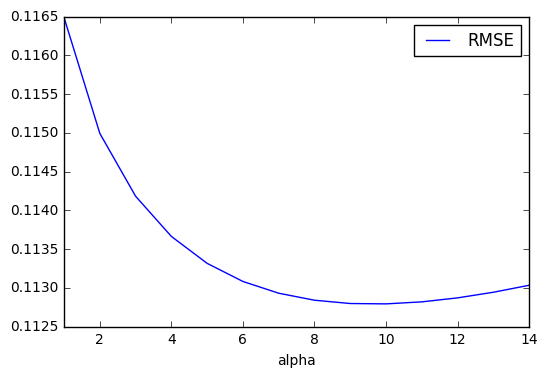

In [12]:
ridge_params = {'alpha': np.arange(1, 15, 1).tolist()}
ridge_df = single_search(ridge_regr, ridge_params)
ridge_df.plot(x = ['alpha'], y = ['RMSE'])
ridge_df.sort_values(['RMSE'], ascending = False)

In [13]:
ridge_regr = linear_model.Ridge(alpha = 10)

In [14]:
validate(ridge_regr)

0.12507228987676239

## Lasso

In [15]:
lasso_regr = linear_model.Lasso(max_iter=50000)

In [16]:
lasso_param = {'alpha': scipy.stats.expon(scale=0.001)}
random_search(lasso_regr, lasso_param, 20)

RandomizedSearchCV took 18.05 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.010 (std: 0.003)
Parameters: {'alpha': 0.0002727117872707258}

Model with rank: 2
Mean validation score: -0.010 (std: 0.003)
Parameters: {'alpha': 0.0002073047887190454}

Model with rank: 3
Mean validation score: -0.010 (std: 0.003)
Parameters: {'alpha': 0.00017017157497746749}



,alpha,RMSE,std dev
5,0.00060000000000000006,0.10392788419817891588,0.05179235814331121374
4,0.00050000000000000001,0.10336126644611778880,0.05192278885445007069
0,0.00010000000000000000,0.10335024739524324711,0.05463325218023014351
3,0.00040000000000000002,0.10271579025033727994,0.05216396325459032868
2,0.00030000000000000003,0.10205678516575686365,0.05290684958472617605
1,0.00020000000000000001,0.10201292982439212620,0.05373233406421305119


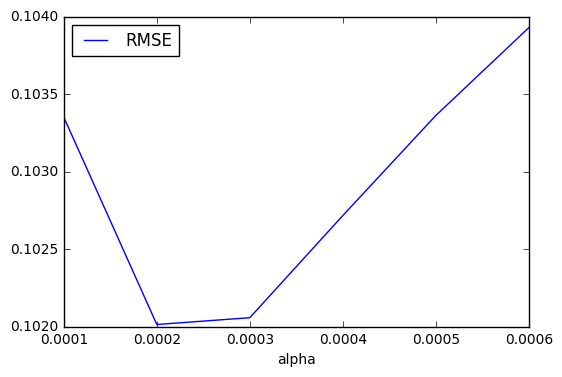

In [17]:
lasso_params = {'alpha': np.arange(0.0001, 0.0007, 0.0001).tolist()}
lasso_df = single_search(lasso_regr, lasso_params)
lasso_df.plot(x = ['alpha'], y = ['RMSE'])
lasso_df.sort_values(['RMSE'], ascending = False)

In [33]:
lasso_regr = linear_model.Lasso(alpha=0.0002, max_iter=50000)

In [34]:
validate(lasso_regr)

0.12086951719150732

## Lasso LARS

In [18]:
lassolars_regr = linear_model.LassoLars(max_iter=50000)

In [19]:
lassolars_param = {'alpha': scipy.stats.expon(scale=0.0001)}
random_search(lassolars_regr, lassolars_param, 20)

/usr/lib64/python2.7/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 144 iterations, i.e. alpha=7.390e-05, with an active set of 124 regressors, and the smallest cholesky pivot element being 2.107e-08
  ConvergenceWarning)
/usr/lib64/python2.7/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 164 iterations, i.e. alpha=5.890e-05, with an active set of 140 regressors, and the smallest cholesky pivot element being 2.581e-08
  ConvergenceWarning)
/usr/lib64/python2.7/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 184 iterations, i.e. alpha=5.251e-05, with an active set of 142 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/usr/lib64/python2.7/site-packages/sklearn/linear_model

RandomizedSearchCV took 8.21 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.010 (std: 0.003)
Parameters: {'alpha': 6.559078287327024e-05}

Model with rank: 2
Mean validation score: -0.010 (std: 0.003)
Parameters: {'alpha': 6.1295997441425029e-05}

Model with rank: 3
Mean validation score: -0.010 (std: 0.003)
Parameters: {'alpha': 8.947861032838035e-05}



/usr/lib64/python2.7/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 273 iterations, i.e. alpha=1.526e-05, with an active set of 209 regressors, and the smallest cholesky pivot element being 2.980e-08
  ConvergenceWarning)
/usr/lib64/python2.7/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 220 iterations, i.e. alpha=2.994e-05, with an active set of 176 regressors, and the smallest cholesky pivot element being 1.825e-08
  ConvergenceWarning)
/usr/lib64/python2.7/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 287 iterations, i.e. alpha=1.200e-05, with an active set of 219 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/usr/lib64/python2.7/site-packages/sklearn/linear_model

,alpha,RMSE,std dev
0,0.00001000000000000000,0.10425760879441206552,0.05333499445927143007
1,0.00002000000000000000,0.10323789878000545761,0.05380385349734288780
2,0.00003000000000000000,0.10239868996272534496,0.05408099509515230247
3,0.00004000000000000000,0.10187958421895645933,0.05433392289232810701
8,0.00009000000000000001,0.10160977946860987042,0.05298095721445954254
4,0.00005000000000000000,0.10160782187460090653,0.05408267584886787549
7,0.00008000000000000001,0.10146554628747730953,0.05318390845482481172
5,0.00006000000000000000,0.10144437321278311492,0.05366967396256986517
6,0.00007000000000000001,0.10137015071141515510,0.05333633816349137025


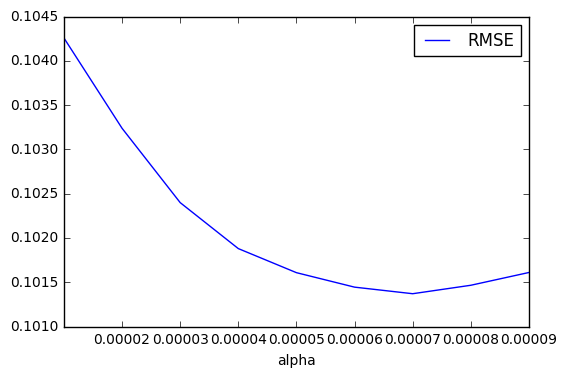

In [35]:
lassolars_params = {'alpha': np.arange(0.00001, 0.00010, 0.00001).tolist()}
lassolars_df = single_search(lassolars_regr, lassolars_params)
lassolars_df.plot(x = ['alpha'], y = ['RMSE'])
lassolars_df.sort_values(['RMSE'], ascending = False)

In [45]:
lassolars_regr = linear_model.LassoLars(alpha=0.00007, max_iter=50000)

In [46]:
validate(lassolars_regr)

0.11773179206932312

## Elastic Net

In [21]:
elnet_regr = linear_model.ElasticNet(max_iter=15000, random_state=7)

In [22]:
elnet_param =  {'alpha': scipy.stats.expon(scale=0.001), 'l1_ratio': scipy.stats.truncnorm(0, 1, loc=0.5, scale=0.25)}
random_search(elnet_regr, elnet_param, 20)

RandomizedSearchCV took 29.92 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.010 (std: 0.003)
Parameters: {'alpha': 0.00048554206870430065, 'l1_ratio': 0.60114019166175958}

Model with rank: 2
Mean validation score: -0.010 (std: 0.003)
Parameters: {'alpha': 0.00051911915364181082, 'l1_ratio': 0.55315226983055288}

Model with rank: 3
Mean validation score: -0.010 (std: 0.003)
Parameters: {'alpha': 0.00056756417796271445, 'l1_ratio': 0.55239048893466058}



,alpha,RMSE,std dev
0,0.00010000000000000000,0.10459737358261084195,0.05429549223927862545
8,0.00090000000000000008,0.10345138678477382166,0.05135870103231263140
1,0.00020000000000000001,0.10324529656290283575,0.05457857696191584923
7,0.00080000000000000004,0.10310293779532760106,0.05153984774716214440
6,0.00070000000000000010,0.10273907551969413410,0.05186157506657288613
5,0.00060000000000000006,0.10241902657730696247,0.05230216314000588756
2,0.00030000000000000003,0.10241756535769447334,0.05381164611820664356
4,0.00050000000000000001,0.10210721506403706849,0.05274448938920579810
3,0.00040000000000000002,0.10203092850391327906,0.05319879427778218678


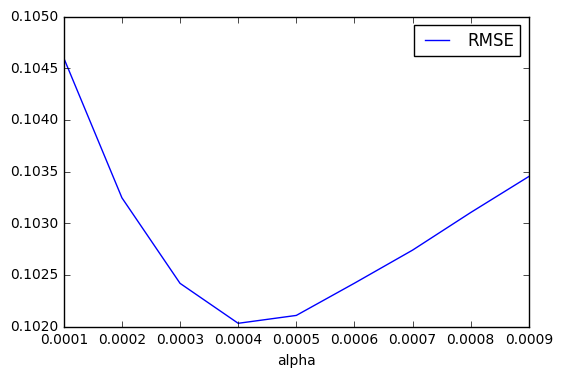

In [36]:
elnet_regr = linear_model.ElasticNet(alpha=0.00038, l1_ratio=0.5, max_iter=15000, random_state=7)
elnet_params = {'alpha': np.arange(0.0001, 0.0010, 0.0001).tolist()}
elnet_df = single_search(elnet_regr, elnet_params)
elnet_df.plot(x = ['alpha'], y = ['RMSE'])
elnet_df.sort_values(['RMSE'], ascending = False)

,l1_ratio,RMSE,std dev
0,0.10000000000000000555,0.10453340240166711372,0.05386811262337964229
1,0.20000000000000001110,0.10347430813326304044,0.05409158283802650846
2,0.30000000000000004441,0.10272008428972756455,0.05384478351657770445
8,0.90000000000000002220,0.10243701983795287791,0.05231034913465480024
3,0.40000000000000002220,0.10225624168035998829,0.05346045599004291271
7,0.80000000000000004441,0.10225000665601077787,0.05254990120344328608
6,0.70000000000000006661,0.10210874930894632551,0.05276474034377688638
5,0.59999999999999997780,0.10203457480662506129,0.05297140853988296233
4,0.50000000000000000000,0.10203092850391327906,0.05319879427778218678


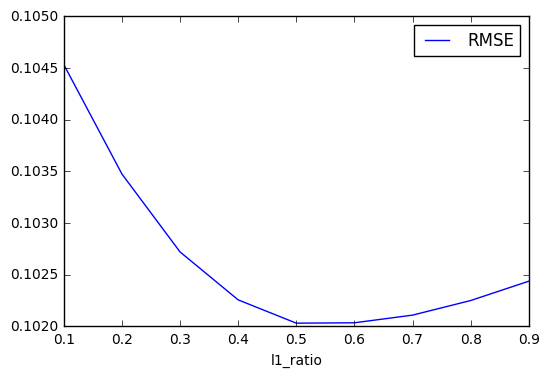

In [47]:
elnet_regr = linear_model.ElasticNet(alpha=0.0004, max_iter=15000, random_state=7)
elnet_params = {'l1_ratio': np.arange(0.1, 1, 0.1).tolist()}
elnet_df = single_search(elnet_regr, elnet_params)
elnet_df.plot(x = ['l1_ratio'], y = ['RMSE'])
elnet_df.sort_values(['RMSE'], ascending = False)

In [48]:
elnet_regr = linear_model.ElasticNet(alpha=0.0004, l1_ratio=0.55, max_iter=15000, random_state=7)

In [49]:
validate(elnet_regr)

0.12091498020222229

## Random Forest

In [24]:
rf_regr = RandomForestRegressor(n_jobs=-1, random_state = 7)

In [25]:
rf_param =  {'n_estimators': scipy.stats.randint(50,400), 'max_depth': scipy.stats.randint(2,40), 
             'max_features': scipy.stats.randint(5,80)}
random_search(rf_regr, rf_param, 20)

RandomizedSearchCV took 187.56 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.015 (std: 0.003)
Parameters: {'max_features': 64, 'n_estimators': 311, 'max_depth': 14}

Model with rank: 2
Mean validation score: -0.015 (std: 0.003)
Parameters: {'max_features': 41, 'n_estimators': 371, 'max_depth': 15}

Model with rank: 3
Mean validation score: -0.015 (std: 0.003)
Parameters: {'max_features': 56, 'n_estimators': 182, 'max_depth': 10}



,n_estimators,RMSE,std dev
0,50.0,0.12147947189036610582,0.05684757341781586371
8,450.0,0.12107489474708964250,0.05496934550580743345
10,550.0,0.12103115717123329176,0.05441586549777371190
11,600.0,0.12102209288314622060,0.05444241823227150695
4,250.0,0.12101267243593863410,0.05491609145131785136
3,200.0,0.12100954951266609805,0.05495931345705244025
9,500.0,0.12097664319102831298,0.05439258970141931659
1,100.0,0.12091304791105156324,0.05464743641033392718
7,400.0,0.12091206695581394048,0.05493135035883409123
2,150.0,0.12084551628719586436,0.05549924636584853410


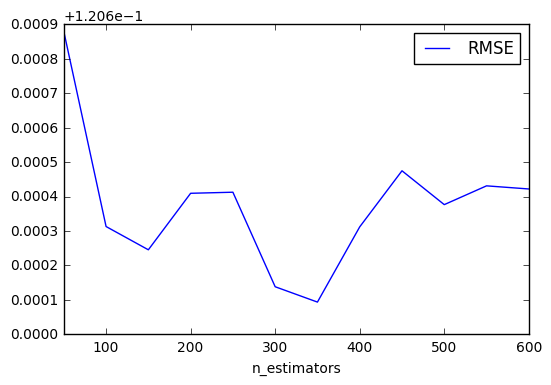

In [55]:
rf_regr = RandomForestRegressor(n_estimators = 311, max_depth = 16, max_features = 82, random_state = 7)
rf_params = {'n_estimators': np.arange(50, 650, 50).tolist()}
rf_df = single_search(rf_regr, rf_params)
rf_df.plot(x = ['n_estimators'], y = ['RMSE'])
rf_df.sort_values(['RMSE'], ascending = False)

In [59]:
rf_regr = RandomForestRegressor(n_estimators = 350, max_depth = 16, max_features = 82, random_state = 7)

In [60]:
validate(rf_regr)

0.13729520207118839

## Support Vector Regressor

In [26]:
svr_regr = svm.SVR(cache_size=200, degree=3, max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [27]:
svr_param = {'C': scipy.stats.expon(scale=1), 'gamma': scipy.stats.expon(scale=.1),
              'kernel': ['rbf']}
random_search(svr_regr, svr_param, 20)

RandomizedSearchCV took 38.06 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.013 (std: 0.003)
Parameters: {'kernel': 'rbf', 'C': 0.90596456128430436, 'gamma': 0.011329850115938844}

Model with rank: 2
Mean validation score: -0.014 (std: 0.003)
Parameters: {'kernel': 'rbf', 'C': 0.48457061185066358, 'gamma': 0.0097927350638205898}

Model with rank: 3
Mean validation score: -0.014 (std: 0.003)
Parameters: {'kernel': 'rbf', 'C': 1.0242516282146397, 'gamma': 0.01838490094121346}



,C,RMSE,std dev
0,0.90000000000000002220,0.11376684472227663325,0.05013085235165419540
1,1.00000000000000000000,0.11321674437401765823,0.05015497449074347164
2,1.10000000000000008882,0.11277415757032537014,0.05025132392287327138
3,1.19999999999999995559,0.11238661654703040182,0.05048657826722264402
4,1.29999999999999982236,0.11213039065913661674,0.05063205385081607363
5,1.39999999999999991118,0.11191081304875807878,0.05074997226702282482
6,1.50000000000000000000,0.11174280142743790722,0.05080311865448833980
7,1.59999999999999986677,0.11161867463412296353,0.05072774291942994118
8,1.69999999999999973355,0.11152866743678423178,0.05065515096889291330
10,1.89999999999999991118,0.11147981420985626777,0.05075108853969481637


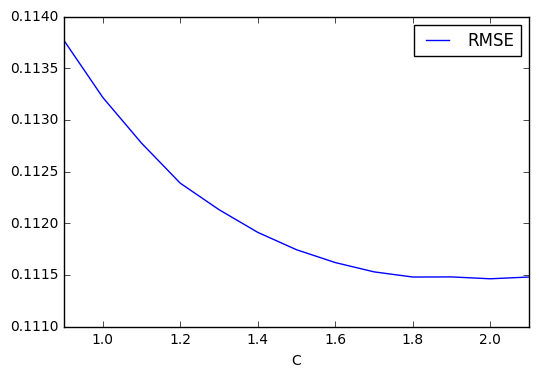

In [56]:
svr_regr = svm.SVR(C=0.9, cache_size=200, coef0=0.0, degree=3, gamma=0.009,
                        kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
svr_params = {'C': np.arange(0.9, 2.1, 0.1).tolist()}
svr_df = single_search(svr_regr, svr_params)
svr_df.plot(x = ['C'], y = ['RMSE'])
svr_df.sort_values(['RMSE'], ascending = False)

In [61]:
svr_regr = svm.SVR(C=2.0, cache_size=200, coef0=0.0, degree=3, gamma=0.009,
                        kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [62]:
validate(svr_regr)

0.13004653604903565

## Orthogonal Matching Pursuit

In [28]:
omp_regr = linear_model.OrthogonalMatchingPursuit()

In [29]:
omp_param = {'n_nonzero_coefs': scipy.stats.randint(20,120)}
random_search(omp_regr, omp_param, 20)

RandomizedSearchCV took 3.77 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.011 (std: 0.003)
Parameters: {'n_nonzero_coefs': 116}

Model with rank: 2
Mean validation score: -0.012 (std: 0.003)
Parameters: {'n_nonzero_coefs': 72}

Model with rank: 2
Mean validation score: -0.012 (std: 0.003)
Parameters: {'n_nonzero_coefs': 72}

Model with rank: 2
Mean validation score: -0.012 (std: 0.003)
Parameters: {'n_nonzero_coefs': 72}



,n_nonzero_coefs,RMSE,std dev
5,95.0,0.10858038470669804931,0.05511910306307978707
8,98.0,0.10856768281119190400,0.05531684344665580705
6,96.0,0.10854704041909862822,0.05511603397636161833
9,99.0,0.10848214384188392678,0.05448976099294567527
0,90.0,0.10839746204083283709,0.05546352884413584955
2,92.0,0.10838487051235376479,0.05523826117424349147
4,94.0,0.10834723357767961360,0.05539986974406591741
7,97.0,0.10833169995877993397,0.05515248968554509190
1,91.0,0.10827663659956715536,0.05548714303428640970
3,93.0,0.10824231251512655971,0.05512952146892501071


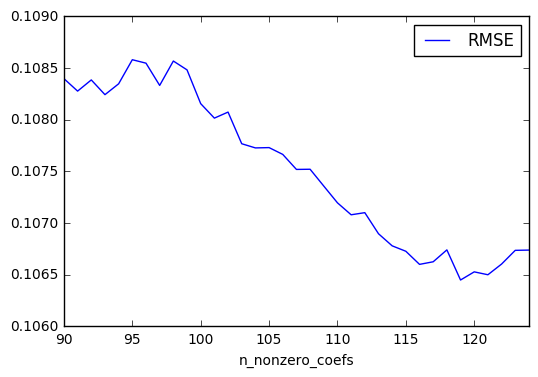

In [52]:
omp_regr = linear_model.OrthogonalMatchingPursuit(n_nonzero_coefs=55)
omp_params = {'n_nonzero_coefs': np.arange(90, 125, 1).tolist()}
omp_df = single_search(omp_regr, omp_params)
omp_df.plot(x = ['n_nonzero_coefs'], y = ['RMSE'])
omp_df.sort_values(['RMSE'], ascending = False)

In [57]:
omp_regr = linear_model.OrthogonalMatchingPursuit(n_nonzero_coefs=119)

In [58]:
validate(omp_regr)

0.12224401212812061

## XGBoost

In [30]:
xgb_regr = xgb.XGBRegressor(seed = 42, nthread = -1, silent = 1)
xgb_param = {'max_depth': scipy.stats.randint(1,10), # Max. Depth [1,∞]
             'min_child_weight': scipy.stats.expon(scale=1), # Min. Child Weight [0,∞]
             'gamma': scipy.stats.expon(scale=1), # Minimum Split Loss, gamma [0,∞]
             'subsample': scipy.stats.uniform(0, 1), # Subsample Ratio of the training instance [0,1]
             'colsample_bytree': scipy.stats.uniform(0, 1), # Subsample Ratio of columns [0,1]
             'reg_alpha': scipy.stats.expon(scale=1), # L1 regularization, alpha [0,∞]
             'reg_lambda': scipy.stats.expon(scale=1), # L2 regularization, lambda [0,∞]
             'learning_rate': scipy.stats.uniform(0, 1), # Step size shrinkage (learning rate) [0,1]
             'n_estimators': scipy.stats.randint(50,500) # Number of boosted trees, n_estimators
            }
random_search(xgb_regr, xgb_param, 20)

RandomizedSearchCV took 4425.43 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.016 (std: 0.003)
Parameters: {'reg_alpha': 0.33783330296722153, 'colsample_bytree': 0.88862334923368413, 'learning_rate': 0.17007803806215083, 'min_child_weight': 0.031207010814228001, 'n_estimators': 304, 'subsample': 0.97408620448496352, 'reg_lambda': 0.2225239678417846, 'max_depth': 5, 'gamma': 0.25960663407609319}

Model with rank: 2
Mean validation score: -0.018 (std: 0.003)
Parameters: {'reg_alpha': 1.2735534067388041, 'colsample_bytree': 0.66256299588927547, 'learning_rate': 0.2509920083300915, 'min_child_weight': 1.3817335357494969, 'n_estimators': 90, 'subsample': 0.95581028006028912, 'reg_lambda': 0.70035228765023483, 'max_depth': 3, 'gamma': 0.19701721560322547}

Model with rank: 3
Mean validation score: -0.020 (std: 0.003)
Parameters: {'reg_alpha': 1.5547050960612667, 'colsample_bytree': 0.032001166488390242, 'learning_rate': 0.865978958874566, 'min_chi

,n_estimators,RMSE,std dev
0,1500.0,0.10737080867996713629,0.05292639924866032047
4,1900.0,0.10730249649796412548,0.05315596609973199244
5,2000.0,0.10730142813430119941,0.05315621860823769446
1,1600.0,0.10728226663499706994,0.05298230516256029893
3,1800.0,0.10726615191836601226,0.05327755355447199442
2,1700.0,0.10724298379640230527,0.05302347954098612925
6,2100.0,0.10722603700182906095,0.05297077487647795790
7,2200.0,0.10717734696324604515,0.05292332095716705681
8,2300.0,0.10714160610979717170,0.05291729239315714345


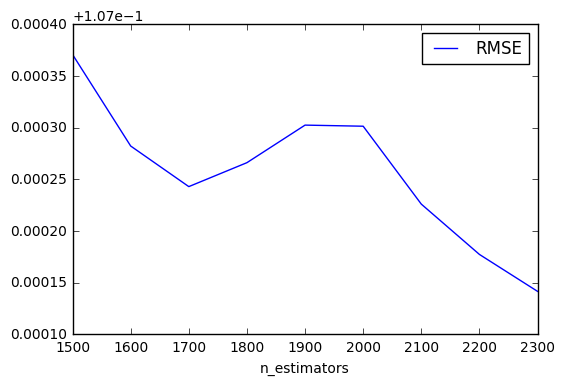

In [77]:
xgb_regr = xgb.XGBRegressor(
    max_depth = 5, 
    min_child_weight = 0.6,
    gamma = 0.03,
    subsample = 0.8,
    colsample_bytree = 0.2,
    reg_alpha = 0.2,
    reg_lambda = 0.4, 
    learning_rate = 0.08,
    n_estimators = 304,
    objective='reg:linear', 
    seed = 42,
    nthread = -1,
    silent = 1)
xgb_params = {'n_estimators': np.arange(1500, 2400, 100).tolist()}
xgb_df = single_search(xgb_regr, xgb_params)
xgb_df.plot(x = ['n_estimators'], y = ['RMSE'])
xgb_df.sort_values(['RMSE'], ascending = False)

In [78]:
xgb_regr = xgb.XGBRegressor(
    max_depth = 5, 
    min_child_weight = 0.6,
    gamma = 0.03,
    subsample = 0.8,
    colsample_bytree = 0.2,
    reg_alpha = 0.2,
    reg_lambda = 0.4, 
    learning_rate = 0.08,
    n_estimators = 2300,
    objective='reg:linear', 
    seed = 42,
    nthread = -1,
    silent = 1)

In [79]:
validate(xgb_regr)

0.12669403163293697

## MLP Regressor

In [31]:
mlp_regr = MLPRegressor(activation='relu', solver='lbfgs', random_state=641,
                        hidden_layer_sizes=(100, ),
                        alpha=0.0001, 
                        tol=0.0001, 
                        max_iter=200)

In [32]:
mlp_regr = MLPRegressor(activation='relu', solver='lbfgs', random_state=641)
mlp_param = {'hidden_layer_sizes': scipy.stats.randint(50,500), # size of a single hidden layer
             'alpha': scipy.stats.expon(scale=0.0001), # L2 regularization,  [0,∞]
             'tol': scipy.stats.expon(scale=0.0001), # Minimum improvement in loss fun. during training
             'max_iter': scipy.stats.uniform(200, 400), # Maximum number of iterations of solver
            }
random_search(mlp_regr, mlp_param, 20)

RandomizedSearchCV took 1726.08 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.018 (std: 0.004)
Parameters: {'alpha': 1.6555713463004503e-05, 'max_iter': 248.91505897538366, 'tol': 8.9498700573263629e-05, 'hidden_layer_sizes': 142}

Model with rank: 2
Mean validation score: -0.018 (std: 0.004)
Parameters: {'alpha': 1.8554351982254167e-06, 'max_iter': 212.41787741419671, 'tol': 1.1561504263036275e-05, 'hidden_layer_sizes': 345}

Model with rank: 3
Mean validation score: -0.018 (std: 0.003)
Parameters: {'alpha': 5.7092547100762549e-06, 'max_iter': 509.26444371332951, 'tol': 7.9266017890399499e-05, 'hidden_layer_sizes': 86}



,max_iter,RMSE,std dev
0,25.0,0.13325194649397645308,0.06578371478862096722
1,50.0,0.11134550709332002860,0.05246992465364867103
2,75.0,0.10831736659977574122,0.05214865299312437114
6,175.0,0.10790550741337628926,0.05340813183737348757
7,200.0,0.10765490543229111475,0.05261955477271879761
5,150.0,0.10736687065973707367,0.05328584096255393338
8,225.0,0.10724582384170519567,0.05103812666831292894
4,125.0,0.10696867311980524928,0.05287986483036793972
3,100.0,0.10688296528409126085,0.05244781844546320820
11,300.0,0.10686560737515231334,0.05093491573123224564


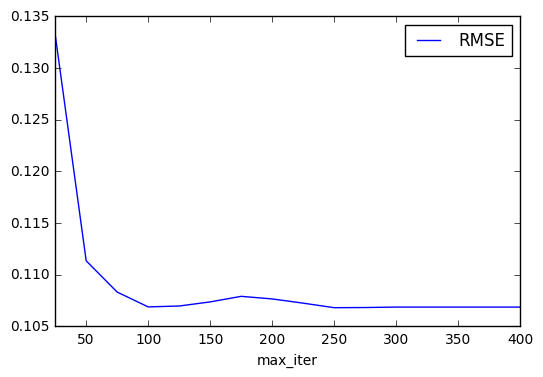

In [68]:
mlp_regr = MLPRegressor(activation='relu', solver='lbfgs', random_state=641,
                        hidden_layer_sizes=(3, ),
                        alpha=0.00008, 
                        tol=0.00017, 
                        max_iter=250)
mlp_params = {'max_iter': np.arange(25, 425, 25).tolist()}
mlp_df = single_search(mlp_regr, mlp_params)
mlp_df.plot(x = ['max_iter'], y = ['RMSE'])
mlp_df.sort_values(['RMSE'], ascending = False)

In [70]:
mlp_regr = MLPRegressor(activation='relu', solver='lbfgs', random_state=641,
                        hidden_layer_sizes=(3, ),
                        alpha=0.00008, 
                        tol=0.00017, 
                        max_iter=250)

In [71]:
validate(mlp_regr)

0.12813039421409278